# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
# sns.set_context("poster")

In [2]:
#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Set the seed value
seed = 123

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [4]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [5]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [6]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

In [7]:
df_transactions.shape, df_offers.shape

((324, 3), (32, 7))

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [8]:
merged = pd.merge(df_transactions, df_offers, how='left', on='offer_id')
pvt = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
pvt


offer_id        1    2    3    4    5    6    7    8    9    10  ...   23  \
customer_name                                                    ...        
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  0.0   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Williams       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
Wilson         0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
Wood           1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   
Wright         0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0   
Young          0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  ...  0.0   

offer_id        24   25   26   27   28   29   30   31   32  
customer_name                                               
Adams          0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
Allen          0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Anderson       1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
Baker          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  
Williams       0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
Wilson         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
Wood           0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
Wright         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Young          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  

[100 rows x 32 columns]

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `X` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Knee Point: 4


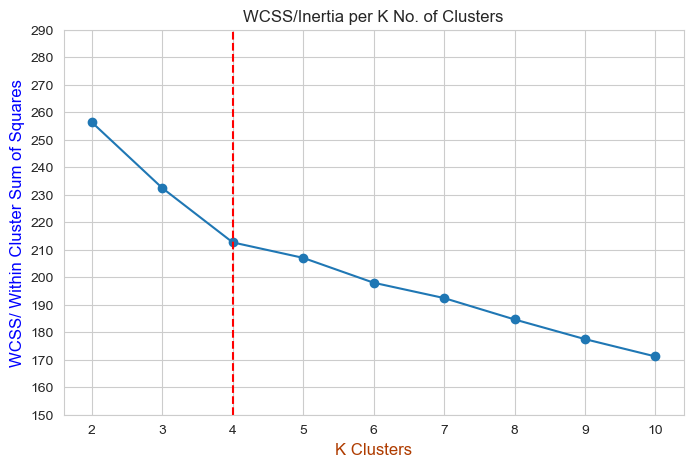

In [9]:
# Create an array to store sum of squares as we iterate through different Ks.
sse = [] 
inertias = []
clusters = {}
Ks = range(2,11)

# Create a numpy matrix `X` with only the columns representing the offers (i.e. the 0/1 colums)
X = pvt.to_numpy()

# Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.
from sklearn.cluster import KMeans
from kneed import KneeLocator


for k in Ks:
    # print(k)
    mdl_km = KMeans(n_clusters=k, random_state=seed)  
    labels = mdl_km.fit_predict(X)
    inertias.append(mdl_km.inertia_ )
    
    centers = mdl_km.cluster_centers_
    sse.append( np.sum((X - centers[labels])**2) ) 
  
    clusters[str(k)] = labels


# Construct a plot showing SS for each K and pick K using this plot. For simplicity, test 2 < K < 10
plt.figure(figsize=(8,5))
plt.plot(Ks, sse, '-o')
plt.xlabel('K Clusters', size=12, c='#AF3C00')
plt.xticks(Ks, size=10)
plt.ylabel('WCSS/ Within Cluster Sum of Squares', size=12, c='blue')
plt.yticks(np.arange(150,300,10),  size=10)
plt.title('WCSS/Inertia per K No. of Clusters')


# Add-on for locating the knee
knee = KneeLocator(Ks, sse, curve='convex', direction='decreasing')
print("Knee Point:", knee.knee)
plt.axvline(knee.knee, color='red', linestyle='--')
plt.show()


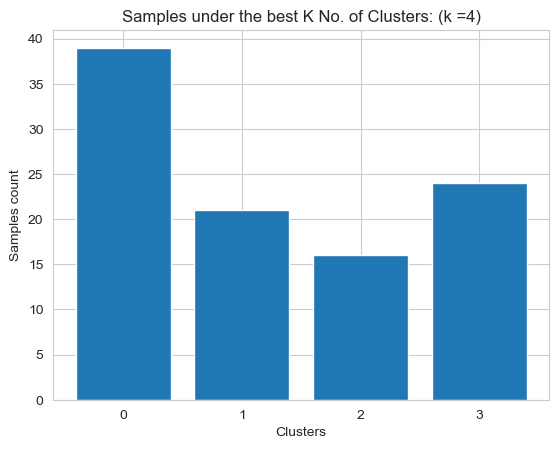

In [10]:
# Make a bar chart showing the number of points in each cluster for k-means under the best K
bestK = 4
bestK_cl = clusters[str(bestK)]
counts = np.bincount(bestK_cl)
plt.bar(range(bestK), counts, align='center')
plt.xlabel('Clusters')
plt.xticks(range(bestK))
plt.ylabel('Samples count')
plt.title(f'Samples under the best K No. of Clusters: (k ={bestK})')
plt.show()


<div class="span5 alert alert-success">
<h4>SOLUTIONS:</h4> 

What values of SS do you believe represent better clusterings? Why?

<ul><li>Using the Elbow/Knee method, K=4 represent better clustering</li></ul>

What challenges did you experience using the Elbow method to pick K?

<ul><li>It is done by eyeballing where the knee/elbow is. It's difficult to tell which among the WCSS values of Ks is the best (not the highest nor the lowest). The kneed was used to pinpoint the knee in the inertia plot.</li></ul>

</div>

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

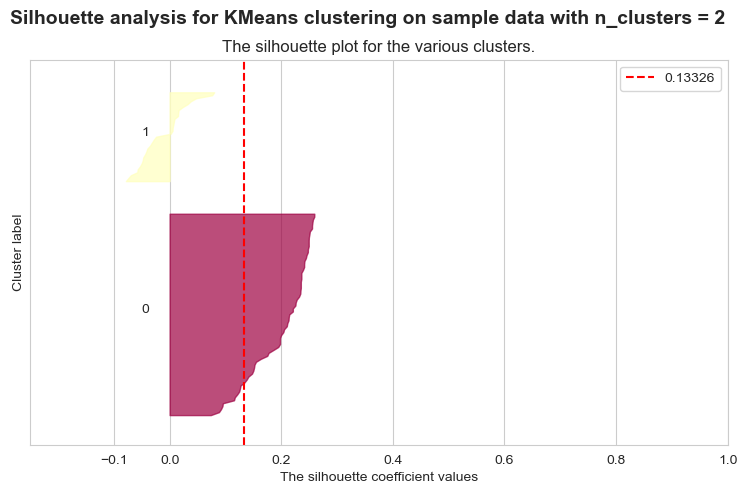

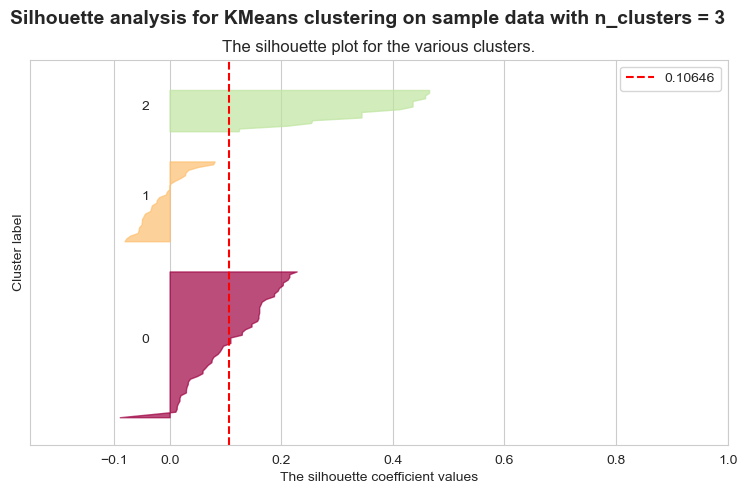

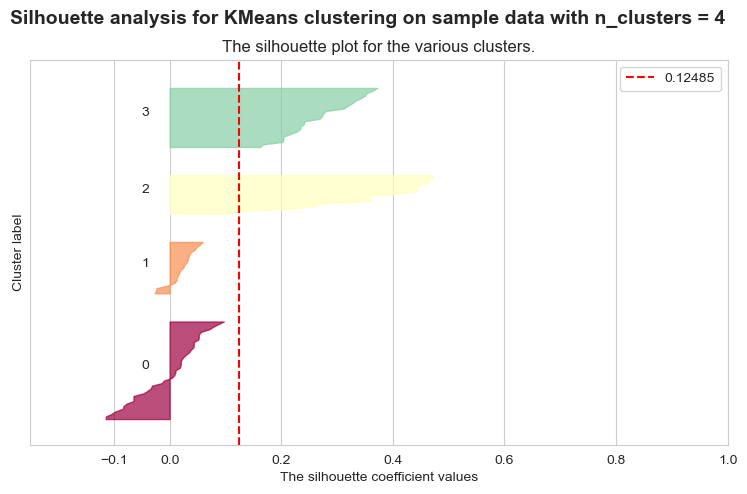

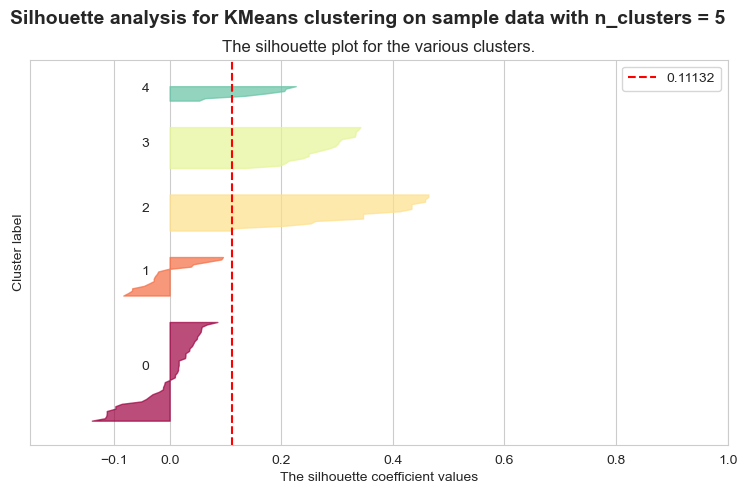

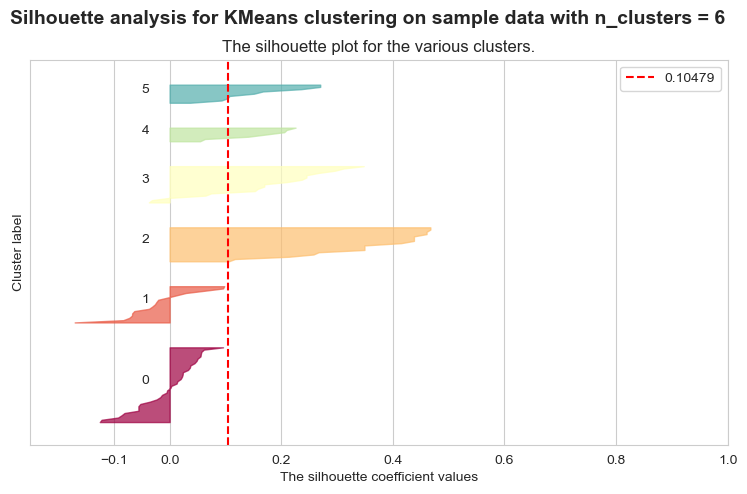

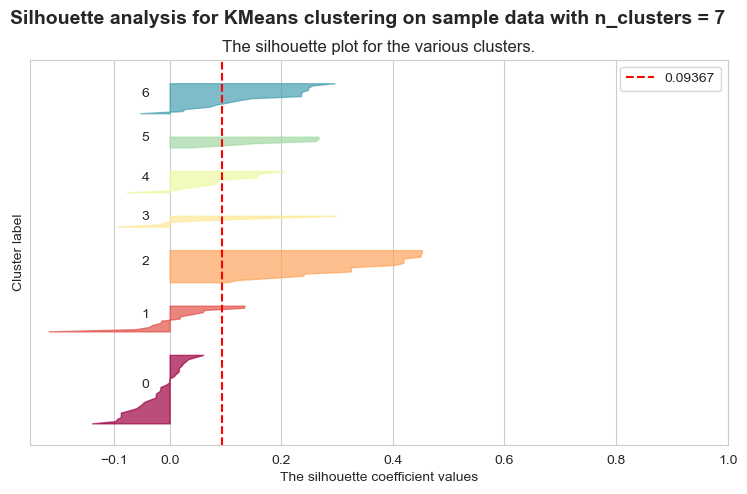

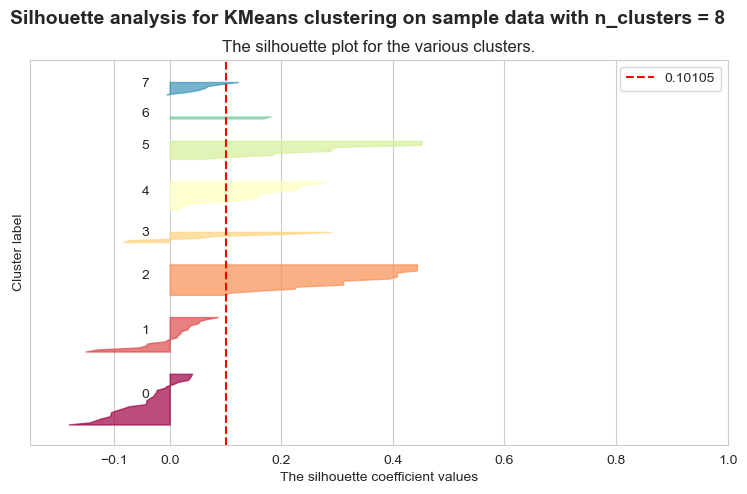

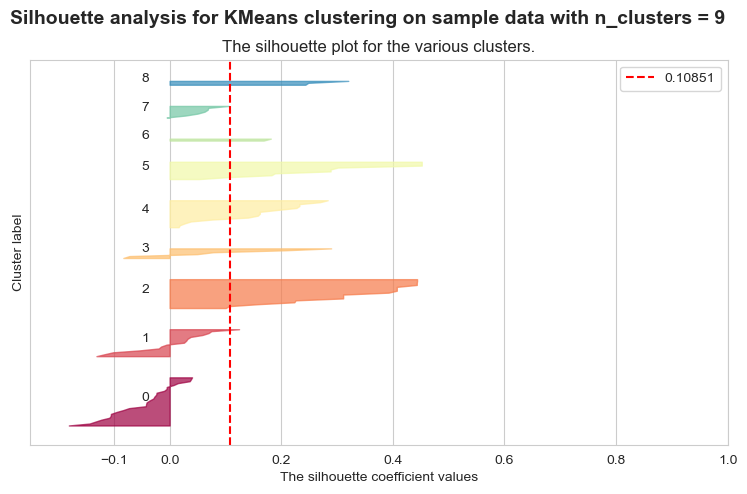

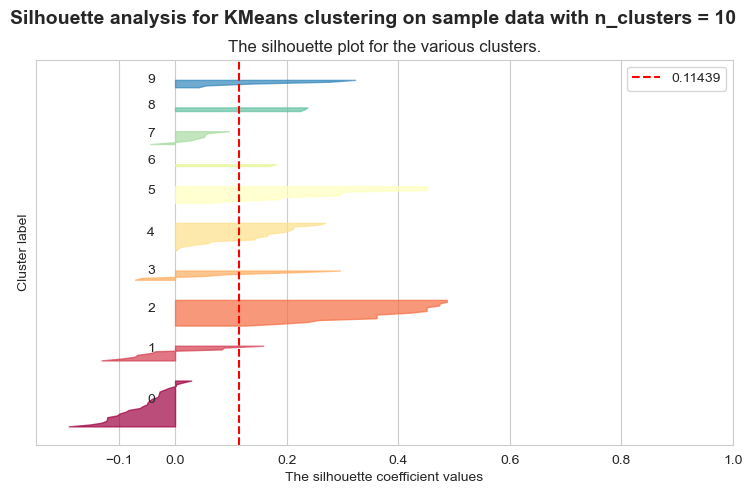

In [11]:
# This is an exercise in adapting someone else's code for our own use; a very common practice for data scientists and programmers alike
# OUR SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import sklearn.metrics
import matplotlib.cm as cm

# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []
avg_per_k = {}

# Iterate through Krange with variable K as before
for k in Ks:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=seed)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    avg_per_k[k] = silhouette_avg
    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

   
    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=silhouette_avg.round(5))

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

In [12]:
# Print Silhouette Average for each K
for k,avg in avg_per_k.items():
    print(f'Silhouette Average for k={k} : {avg.round(5)}')

Silhouette Average for k=2 : 0.13326
Silhouette Average for k=3 : 0.10646
Silhouette Average for k=4 : 0.12485
Silhouette Average for k=5 : 0.11132
Silhouette Average for k=6 : 0.10479
Silhouette Average for k=7 : 0.09367
Silhouette Average for k=8 : 0.10105
Silhouette Average for k=9 : 0.10851
Silhouette Average for k=10 : 0.11439


Text(0.5, 1.0, 'Silhouette Score per K Number of Clusters')

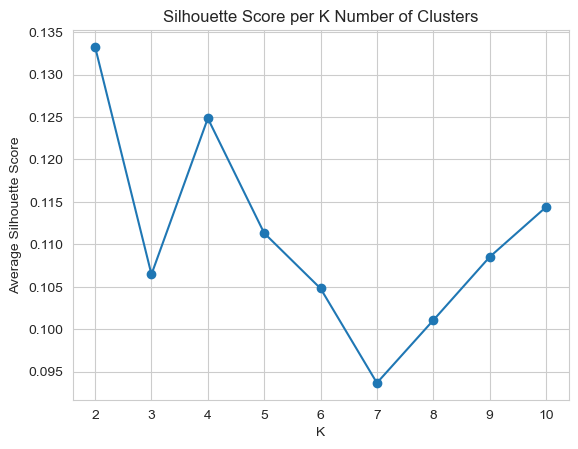

In [13]:
# Determine the best k by plotting the silhouette average 
plt.plot(Ks, avg_silhouette_scores, '-o')
plt.xlabel('K')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score per K Number of Clusters')


<div class="span5 alert alert-success">
<h4>SOLUTIONS:</h4> 

Compute the average silhouette score for each $K$ and plot it. 

What $K$ does the plot suggest we should choose? 
<ul>
    <li>Based on the plot, the ideal K = 4. While K=2 has the highest silhouette score that we tested, the shape of the labels is not ideal as it's not distributed equally compared to K=4. Also, K=4 has the least negative silhouette coefficients among the tested Ks.</li></ul>

Does it differ from what we found using the Elbow method?</p>
<ul>
    <li>Yes, because in the first exercise, we are only measuring WCSS/inertia whereas in this exercise, we measure the silhouette coefficients and their average(score).</li></ul>
</div>

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes‚ÄìMallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

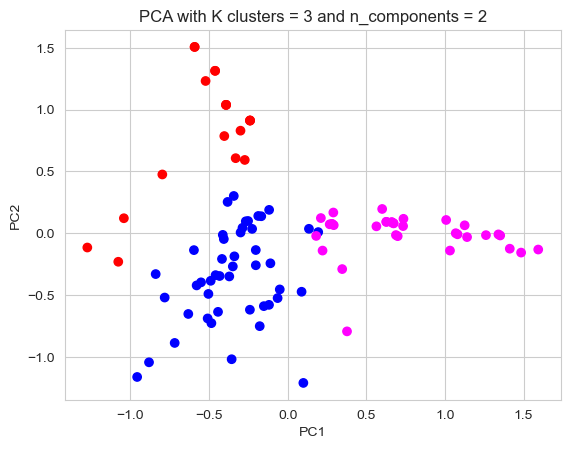

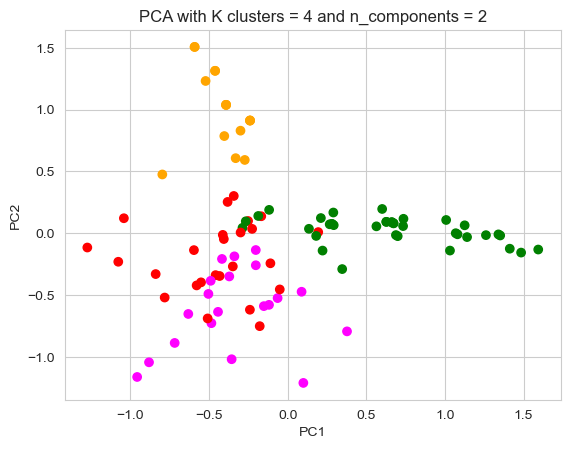

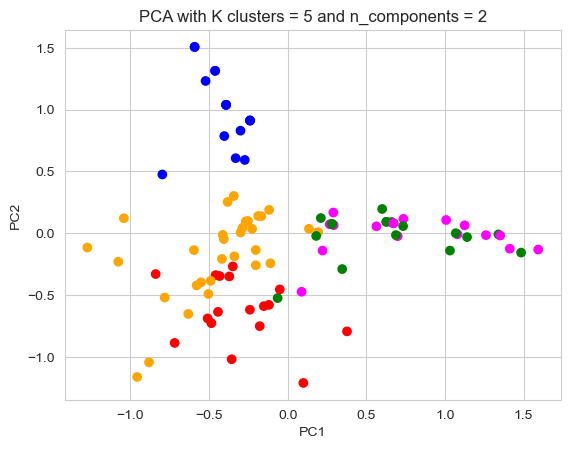

In [14]:
import sklearn.decomposition
import matplotlib.colors
from sklearn.cluster import KMeans

Ks_pcatest = [3, 4, 5]
for k in Ks_pcatest:
    # Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
    mdl_km = KMeans(n_clusters=k)
    # Call a fit_predict() on X 
    cluster_assignments = mdl_km.fit_predict(X)
    
    # Let's visualiaze with colors.ListedColormap
    cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue', 'orange', 'magenta'])
    
    # We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
    pca = sklearn.decomposition.PCA(n_components=2, random_state=seed)
    pc1, pc2 = zip(*pca.fit_transform(X))

    
    # fig, ax1 = plt.subplots(1, 1)
    plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
    plt.title(f'PCA with K clusters = {k} and n_components = 2')  
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [15]:
offer_proportions = pvt.sum(axis=0) / 100
offer_proportions.shape

(32,)

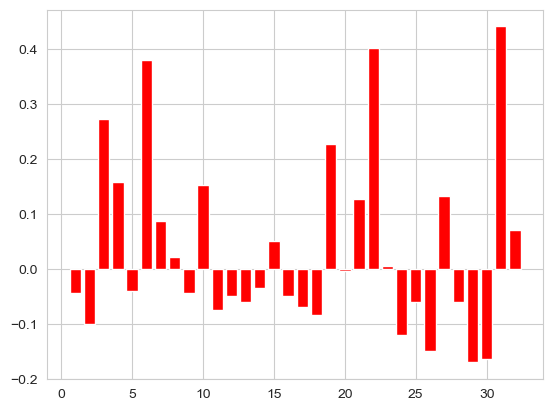

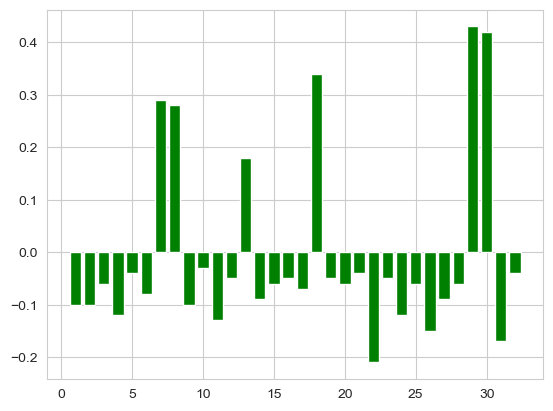

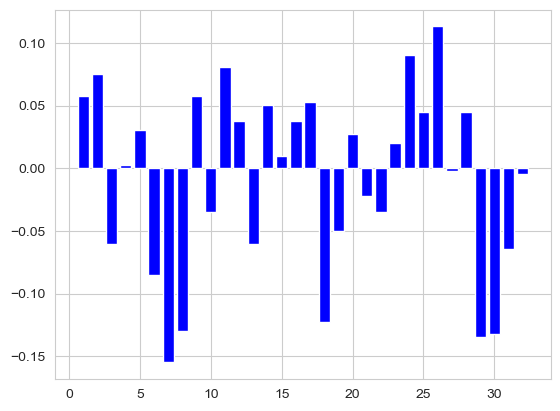

In [16]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = pvt.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = pvt[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

<div class="span5 alert alert-success">
<h4>SOLUTIONS:</h4> 
How do the clusters look? 
<ul><li>Using the PCA-transformed data, the clustering doesn't appear to be optimal</li></ul>

Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
<ul><li>After reducing the dimensionality and by assessing visually, the clusters look better with K=3 among the ones we tested</li></ul>

</div>

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

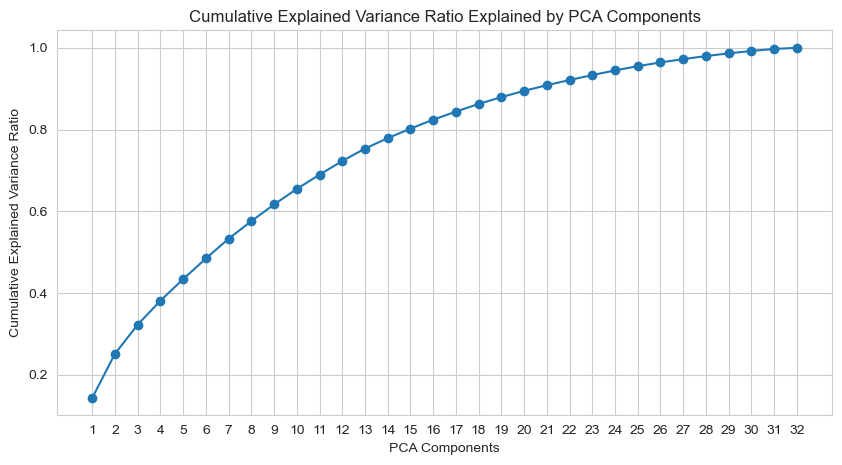

In [17]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit_transform(X)

evr = pca.explained_variance_ratio_
ev = pca.explained_variance_

plt.figure(figsize=(10,5))
plt.plot( evr.cumsum(), '-o')
plt.xlabel('PCA Components')
plt.xticks(np.reshape([np.arange(0, len(evr), 1)], -1), np.reshape(([np.arange(1, len(evr)+1,1)]), -1))
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio Explained by PCA Components')
plt.show()


## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. Assigns cluster labels based on dense region of points. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size. It does not partition datasets int hierarchies that require a manual cut-off point. One advantage is it can remove [noise]* points.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [18]:
# Use PCA to reduce the dimensionality of the pivoted dataset. 
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed)
X_pca = pca.fit_transform(X)

### 1. Affinity Propagation

In [19]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

prefs = np.linspace(-50, -10, 5).tolist()

# Store silhouette scores and other metrics
ap_metrics ={}

# Compute Affinity Propagation
for i, pref in enumerate(prefs):
    ap_model = AffinityPropagation(preference=pref, random_state=seed).fit(X_pca)

    labels = ap_model.labels_
    
    cluster_centers_indices = ap_model.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    # print(cluster_centers_indices)
    
    ap_score = None
    if n_clusters_ >= 2: #read somewhere silhouette scores only work with cluster_centers > 2
        ap_score = metrics.silhouette_score(X_pca, ap_model.labels_ )

    ap_metrics[pref] = {'n_cluster': n_clusters_ , 'score': ap_score} #'homogeneity': homogeneity, 'completeness': completeness}

# Display the metrics
ap_metrics

{-50.0: {'n_cluster': 1, 'score': None},
 -40.0: {'n_cluster': 1, 'score': None},
 -30.0: {'n_cluster': 1, 'score': None},
 -20.0: {'n_cluster': 3, 'score': 0.5303468047950125},
 -10.0: {'n_cluster': 3, 'score': 0.4930701753912993}}

The optimal parameters are pref= -0.20 and n_clusters = 3 as the silhouette score yielded 0.53.

### 2. Spectral Clustering

We'll test and obtain the silhouette scores of the two affinities: rbf, and nearest-neighbors.

In [20]:
from sklearn.cluster import SpectralClustering

k = 4
# Using RBF
mdl_scrbf = SpectralClustering(n_clusters = k, affinity ='rbf') 
labels_rbf = mdl_scrbf.fit_predict(X_pca) 
print(f'Silhouette Score with rbf and k= {k} : {metrics.silhouette_score(X_pca, labels_rbf)}')


# Using Nearest Neighbor
mdl_scnn = SpectralClustering(n_clusters = k, affinity ='nearest_neighbors') 
labels_nn = mdl_scnn.fit_predict(X_pca)
print(f'Silhouette Score with Nearest Neighbor and k= {k} : {metrics.silhouette_score(X_pca, labels_nn)}')


Silhouette Score with rbf and k= 4 : 0.37908699847414246
Silhouette Score with Nearest Neighbor and k= 4 : 0.3787921918236669


### 3. Agglomerative Clustering

Text(0, 0.5, 'Silhouette Score (Mean)')

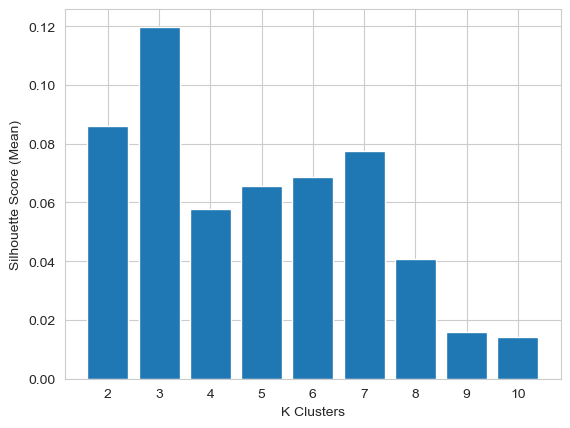

In [21]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

# First determine the optimal k cluster using the silhouette method
k_clusters = np.array(range(2, 11))
scores = {}

for k in k_clusters:
    mdl_ac = AgglomerativeClustering(n_clusters = k)
    cluster_labels = mdl_ac.fit_predict(X_pca)
    scores[k] = metrics.silhouette_score(X, cluster_labels)

plt.bar(scores.keys(), scores.values())
plt.xlabel('K Clusters')
plt.xticks(np.arange(2,max(k_clusters)+1, 1))
plt.ylabel('Silhouette Score (Mean)')


Although the silhouette score is suboptimal (only at ~0.12), this is the highest so the best k number of clusters is 3.

#### 4. DBSCAN

Notes: two hyperparameters in DBSCAN (MinPts and ùúÄùúÄ ) that need to be optimized to yield good clustering results. Finding a good combination of MinPts and ùúÄùúÄ can be problematic if the density differences in the dataset are relatively large. Create a k-distance graph to guide us in selecting the appropriate epsilon value. Steps:
Calculate the distance to the k-th nearest neighbor for each point.
Sort and plot the distance and use the elbow method to choose the epsilon. 

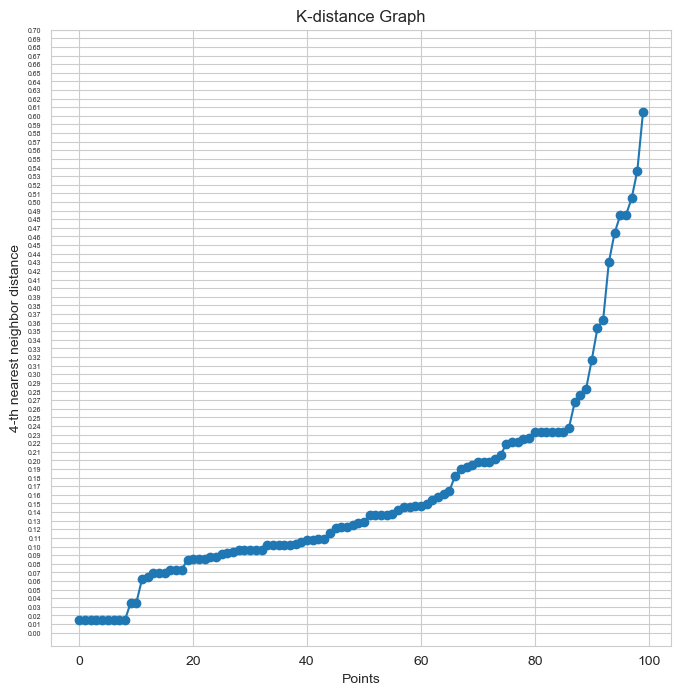

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

k=4
mdl_nn = NearestNeighbors(n_neighbors=k)
mdl_nn.fit(X_pca)

distances, indices = mdl_nn.kneighbors(X_pca)
distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 8))
plt.plot(distances, '-o')

plt.xlabel('Points')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.yticks(np.arange(0, max(distances)+0.1, 0.01), fontsize=5)
plt.title('K-distance Graph')
plt.show()
             

Using the Elbow method, the estimated ùúÄùúÄ = 0.23

Note: It's difficult to determine the optimal number of observations that must be nearby to be considered a core point, as it will depend on the density of the data.

In [23]:
epsilon = 0.23
min_samples = 10

mdl_dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean') #default:euclidean
clusters = mdl_dbscan.fit_predict(X_pca)
labels = mdl_dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 47
